# Wavelets and the Wavlet Transform

# The General Wavelet Transform Equation

# Short Time Fourier Transform vs Wavelet Transform

# Application: Signal Denoising

In [7]:
using Plots, WAV, Wavelets

In [3]:
y,fs,_,_ = wavread("joe.wav");

In [5]:
xt = dwt(y, wavelet(WT.db2))

70393×1 Array{Float64,2}:
 0.0020142216254158147
 0.0022583697012237922
 0.00173955504013184
 0.0011902218695638905
 0.0011291848506118961
 0.0013428144169438765
 0.0012207403790398877
 0.0012512588885158849
 0.0009765923032319102
 0.0005798516800439467
 0.0006714072084719382
 0.0010681478316599017
 0.0011597033600878933
 ⋮
 0.0021668141727958007
 0.0021362956633198035
 0.002075258644367809
 0.0019837031159398175
 0.0021362956633198035
 0.0019226660969878231
 0.0019531846064638203
 0.0021057771538438063
 0.0018311105685598315
 0.0018311105685598315
 0.0019226660969878231
 0.0

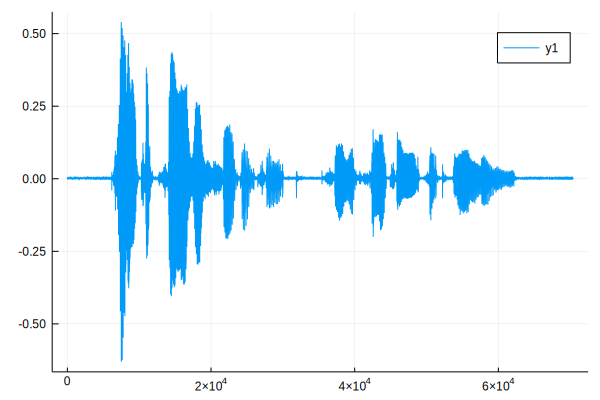

In [8]:
plot(xt)

$$\LARGE X_{a,b} = \int_{-\infty}^{\infty} \! x(t) * \psi_{a,b}(t) \, \mathrm{d}t $$